In [1]:
import tensorflow as tf
from tensorflow.keras import layers

import re
import string
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

2023-06-23 11:35:27.466493: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
UNITS = 256

### Load dataset

In [3]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
"Running in colab" if IN_COLAB else "Running locally"

'Running locally'

### Init wandb

In [4]:
if IN_COLAB:
  !pip install wandb -q

import wandb

from wandb.keras import (
   WandbMetricsLogger,
   WandbModelCheckpoint,
)

# from ruamel.yaml import YAML

# yaml=YAML(typ='safe')
# with open('params.yaml', 'r') as file:
#     config_file = yaml.load(file)

# config_file = yaml.load(
# """
# """
# )

In [5]:
wandb.login(key="5cf270b076069df1abe8111873de4d61ba8a6819")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: amirfvb. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/amir/.netrc


True

In [6]:
wandb.init(
    # set the wandb project where this run will be logged
    project="CRNN_translate",

    # name="test_log_code",
    # notes="Removed gradient clipping",
    # config=config_file,
    save_code=True,
)
# wandb.run.log_code(include_fn=lambda path: path.endswith("params.yaml")
#                                         or path.endswith("model.py")
#                                         or path.endswith("wandb_mnist.py"))
config = wandb.config

In [7]:
if IN_COLAB:
    # download dataset

    import pathlib

    path_to_zip = tf.keras.utils.get_file(
        'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
        extract=True)

    path_to_file = pathlib.Path(path_to_zip).parent/'spa-eng/spa.txt'

    def load_data(path):
        text = path.read_text(encoding='utf-8')

        lines = text.splitlines()
        pairs = [line.split('\t') for line in lines]

        context = np.array([context for target, context in pairs])
        target = np.array([target for target, context in pairs])

        return target, context

    target_raw, context_raw = load_data(path_to_file)

    print(context_raw[-1])
    print(target_raw[-1])

else:
    df = pd.read_csv("data/spa-eng.zip", delimiter="\t", names=["translate", "source", "attr"])
    context_raw = np.array(df["source"])
    target_raw = np.array(df["translate"])
    print(context_raw[-1])
    print(target_raw[-1])

BUFFER_SIZE = len(context_raw)
BATCH_SIZE = 64

is_train = np.random.uniform(size=(len(target_raw),)) < 0.8 # todo. Check reproducibility and across methods (colab/not colab)


train_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[is_train], target_raw[is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))
val_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[~is_train], target_raw[~is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))



Un día, me desperté y vi que Dios me había puesto pelo en la cara. Me lo afeité. Al día siguiente, vi que Dios me lo había vuelto a poner en la cara, así que me lo afeité otra vez. Al tercer día, cuando vi que Dios me había puesto pelo en la cara de nuevo, decidí que Dios se saliera con la suya. Por eso tengo barba.
One day, I woke up to find that God had put hair on my face. I shaved it off. The next day, I found that God had put it back on my face, so I shaved it off again. On the third day, when I found that God had put hair back on my face again, I decided to let God have his way. That's why I have a beard.


#### My dataset processing

In [8]:
def custom_standardization(text):

  text = tf.strings.lower(text)
  text = tf.strings.regex_replace(text,
                                  '[%s]' % re.escape(string.punctuation + "¿¡"), '')
  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text
vocab_size = 5000
# sequence_length = 250



context_text_processor = tf.keras.layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    ragged=True)

context_text_processor.adapt(train_raw.map(lambda context, target: context))

# Here are the first 10 words from the vocabulary:
context_text_processor.get_vocabulary()[:10]

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


['', '[UNK]', '[START]', '[END]', 'de', 'que', 'no', 'tom', 'a', 'la']

In [9]:
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    ragged=True)

target_text_processor.adapt(train_raw.map(lambda context, target: target))
target_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', 'i', 'the', 'to', 'you', 'tom', 'a']

#### tf dataset processing

In [38]:
# if IN_COLAB:
#   !pip install "tensorflow-text>=2.11" -q
# import tensorflow_text as tf_text


In [39]:
# def tf_lower_and_split_punct(text):
#   # Split accented characters.
#   text = tf_text.normalize_utf8(text, 'NFKD')
#   text = tf.strings.lower(text)
#   # Keep space, a to z, and select punctuation.
#   text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
#   # Add spaces around punctuation.
#   text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
#   # Strip whitespace.
#   text = tf.strings.strip(text)

#   text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
#   return text

In [40]:
# max_vocab_size = 5000

# context_text_processor = tf.keras.layers.TextVectorization(
#     standardize=tf_lower_and_split_punct,
#     max_tokens=max_vocab_size,
#     ragged=True)

In [41]:
# context_text_processor.adapt(train_raw.map(lambda context, target: context))

# # Here are the first 10 words from the vocabulary:
# context_text_processor.get_vocabulary()[:10]

In [42]:
# target_text_processor = tf.keras.layers.TextVectorization(
#     standardize=tf_lower_and_split_punct,
#     max_tokens=max_vocab_size,
#     ragged=True)

# target_text_processor.adapt(train_raw.map(lambda context, target: target))
# target_text_processor.get_vocabulary()[:10]

#### End of text processings

In [10]:
def process_text(context, target):
  context = context_text_processor(context).to_tensor()
  target = target_text_processor(target)
  targ_in = target[:,:-1].to_tensor()
  targ_out = target[:,1:].to_tensor()
  return (context, targ_in), targ_out


train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

### define model

In [11]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, text_processor, units):
    super(Encoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.units = units

    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size, units,
                                               mask_zero=True)

    # The RNN layer processes those vectors sequentially.
    self.rnn = tf.keras.layers.Bidirectional(
        merge_mode='sum',
        layer=tf.keras.layers.GRU(units,
                            # Return the sequence and state
                            return_sequences=True,
                            recurrent_initializer='glorot_uniform'))

  def call(self, x):
    # 2. The embedding layer looks up the embedding vector for each token.
    x = self.embedding(x)

    # 3. The GRU processes the sequence of embeddings.
    x = self.rnn(x)

    # 4. Returns the new sequence of embeddings.
    return x

  def convert_input(self, texts):
    texts = tf.convert_to_tensor(texts)
    if len(texts.shape) == 0:
      texts = tf.convert_to_tensor(texts)[tf.newaxis]
    context = self.text_processor(texts).to_tensor()
    context = self(context)
    return context

In [12]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self, units, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

  def call(self, x, context):

    attn_output, attn_scores = self.mha(
        query=x,
        value=context,
        return_attention_scores=True)

    # Cache the attention scores for plotting later.
    attn_scores = tf.reduce_mean(attn_scores, axis=1)
    self.last_attention_weights = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [13]:
class Decoder(tf.keras.layers.Layer):

  def __init__(self, text_processor, units):
    super(Decoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.word_to_id = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]')
    self.id_to_word = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]',
        invert=True)
    self.start_token = self.word_to_id('[START]')
    self.end_token = self.word_to_id('[END]')

    self.units = units


    # 1. The embedding layer converts token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                               units, mask_zero=True)

    # 2. The RNN keeps track of what's been generated so far.
    self.rnn = tf.keras.layers.GRU(units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    # 3. The RNN output will be the query for the attention layer.
    self.attention = CrossAttention(units)

    # 4. This fully connected layer produces the logits for each
    # output token.
    self.output_layer = tf.keras.layers.Dense(self.vocab_size)

  def call(self,
          context, x,
          state=None,
          return_state=False):

    # 1. Lookup the embeddings
    x = self.embedding(x)

    # 2. Process the target sequence.
    x, state = self.rnn(x, initial_state=state)

    # 3. Use the RNN output as the query for the attention over the context.
    x = self.attention(x, context)
    self.last_attention_weights = self.attention.last_attention_weights

    # Step 4. Generate logit predictions for the next token.
    logits = self.output_layer(x)

    if return_state:
      return logits, state
    else:
      return logits

  def get_initial_state(self, context):
    batch_size = tf.shape(context)[0]
    start_tokens = tf.fill([batch_size, 1], self.start_token)
    done = tf.zeros([batch_size, 1], dtype=tf.bool)
    embedded = self.embedding(start_tokens)
    return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

  def tokens_to_text(self, tokens):
    words = self.id_to_word(tokens)
    result = tf.strings.reduce_join(words, axis=-1, separator=' ')
    result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
    result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
    return result

  def get_next_token(self, context, next_token, done, state, temperature = 0.0):
    logits, state = self(
      context, next_token,
      state = state,
      return_state=True)

    if temperature == 0.0:
      next_token = tf.argmax(logits, axis=-1)
    else:
      logits = logits[:, -1, :]/temperature
      next_token = tf.random.categorical(logits, num_samples=1)

    # If a sequence produces an `end_token`, set it `done`
    done = done | (next_token == self.end_token)
    # Once a sequence is done it only produces 0-padding.
    next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)

    return next_token, done, state



In [14]:
class Translator(tf.keras.Model):

  def __init__(self, units,
               context_text_processor,
               target_text_processor):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(context_text_processor, units)
    decoder = Decoder(target_text_processor, units)

    self.encoder = encoder
    self.decoder = decoder

  def call(self, inputs):
    context, x = inputs
    # logging.debug(f"got context {context}, and x {x}")
    context = self.encoder(context)
    # logging.debug("encoded")
    logits = self.decoder(context, x)
    # logging.debug("decoded")

    #TODO(b/250038731): remove this
    try:
      # Delete the keras mask, so keras doesn't scale the loss+accuracy.
      del logits._keras_mask
    except AttributeError:
      pass

    return logits

  def translate(self,
              texts, *,
              max_length=50,
              temperature=0.0):
    # Process the input texts
    context = self.encoder.convert_input(texts)
    batch_size = tf.shape(texts)[0]

    # Setup the loop inputs
    tokens = []
    attention_weights = []
    next_token, done, state = self.decoder.get_initial_state(context)

    for _ in range(max_length):
      # Generate the next token
      next_token, done, state = self.decoder.get_next_token(
          context, next_token, done,  state, temperature)

      # Collect the generated tokens
      tokens.append(next_token)
      attention_weights.append(self.decoder.last_attention_weights)

      if tf.executing_eagerly() and tf.reduce_all(done):
        break

    # Stack the lists of tokens and attention weights.
    tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
    self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

    result = self.decoder.tokens_to_text(tokens)
    return result

In [15]:
model = Translator(UNITS, context_text_processor, target_text_processor)

In [16]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [17]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)

    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)

    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [18]:
model.compile(optimizer='adam',
              loss=masked_loss,
              metrics=[masked_acc, masked_loss])

In [20]:
history = model.fit(
    train_ds.repeat(),
    epochs=10,
    steps_per_epoch = 100,
    validation_data=val_ds,
    validation_steps = 20,  # todo -- убедиться, что это не делает ничего странного.
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3),
        WandbMetricsLogger()])

Epoch 1/10
100/100 [==============================] - 35s 255ms/step - loss: 5.6930 - masked_acc: 0.1753 - masked_loss: 5.6930 - val_loss: 5.0003 - val_masked_acc: 0.2303 - val_masked_loss: 5.0003
Epoch 2/10
100/100 [==============================] - 24s 242ms/step - loss: 4.4804 - masked_acc: 0.2953 - masked_loss: 4.4804 - val_loss: 4.0168 - val_masked_acc: 0.3456 - val_masked_loss: 4.0168
Epoch 3/10
100/100 [==============================] - 29s 286ms/step - loss: 3.7618 - masked_acc: 0.3833 - masked_loss: 3.7618 - val_loss: 3.4267 - val_masked_acc: 0.4248 - val_masked_loss: 3.4267
Epoch 4/10
100/100 [==============================] - 26s 257ms/step - loss: 3.2510 - masked_acc: 0.4515 - masked_loss: 3.2510 - val_loss: 2.9815 - val_masked_acc: 0.4867 - val_masked_loss: 2.9815
Epoch 5/10
100/100 [==============================] - 24s 239ms/step - loss: 2.8835 - masked_acc: 0.5041 - masked_loss: 2.8835 - val_loss: 2.7319 - val_masked_acc: 0.5292 - val_masked_loss: 2.7319
Epoch 6/10
100/

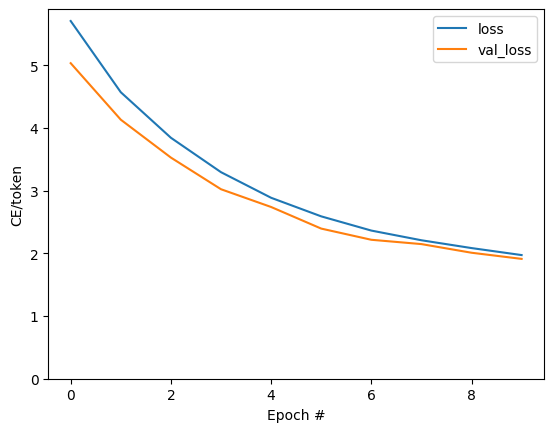

In [54]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

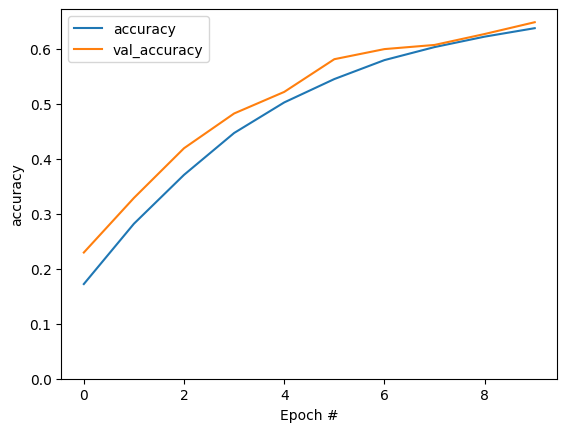

In [55]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('accuracy')
plt.legend()

In [56]:
result = model.translate(['¿Todavía está en casa?']) # Are you still home
result[0].numpy().decode()

'its still in home '

In [57]:
# for i in range(len(history.history['masked_acc'])):
#   wandb.log({
#   # print({
#       "train_accuracy": history.history['masked_acc'][i],
#       "test_accuracy": history.history['val_masked_acc'][i],
#       "train_loss": history.history['masked_loss'][i],
#       "test_loss": history.history['val_masked_loss'][i],
#   })

In [58]:
wandb.finish()

epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▃▃▂▂▁▁▁
epoch/masked_acc,▁▃▄▅▆▇▇▇██
epoch/masked_loss,█▆▅▃▃▂▂▁▁▁
epoch/val_loss,█▆▅▃▃▂▂▂▁▁
epoch/val_masked_acc,▁▃▄▅▆▇▇▇██
epoch/val_masked_loss,█▆▅▃▃▂▂▂▁▁
epoch/epoch,9
epoch/learning_rate,0.001
epoch/loss,1.97213
